# Effect of most common ethnicity in authorship on the distribution of the citing articles

In [1]:
import re
import pandas as pd
import numpy as np
import pickle
import ethnicity_funcs as ef
import pylab as pl
from disambig_funcs import Gini
from scipy.stats import pearsonr
from statistics import mode,StatisticsError
from collections import Counter
from random import choice

In [2]:
# Utility functions

# Return mode, or NaN if no unique mode found
def uniqueMode(tmp):
    try:
        return mode(tmp)
    except StatisticsError:
        return np.nan

## Reading in the data files and some pre-processing

In [3]:
baseField='MechanicalEngineering'
ethFile='ethnicitiesMech.pkl'

In [4]:
# Loading in the CSV files
ethdict=pickle.load(open(ethFile,"rb"))
paa=pd.read_csv(baseField+"SelectedPaperAuthorAffiliations.txt",'\t',usecols=[0,1],names=['pid','aid'])
authors=pd.read_csv(baseField+'SelectedAuthors.txt','\t',names=['aid','name'])
refs=pd.read_csv(baseField+"SelectedPaperReferences.txt",'\t',names=['pid','refpid'])

In [5]:
# Creating file with pid,aid,name,eth
df=pd.merge(paa,authors,on='aid')
df['eth']=df.name.apply(lambda tmp: ef.name2ethnicity(tmp,ethdict))

In [6]:
# Creating lookup dict from pid to ';' delimited eths
pid_eths=df.groupby('pid')['eth'].apply(lambda tmp:';'.join(tmp)).reset_index().rename(columns={'eth':'eths'})
pideths_dict=dict(pid_eths.itertuples(index=False))

# Most common ethnicity for each paper
pid_eths['ethmode']=pid_eths['eths'].apply(lambda tmp:uniqueMode(tmp.split(';')))
pid_eths=pid_eths.dropna()

In [7]:
# Calculating default ethnicity frequencies
ethpdf=df.eth.value_counts(normalize=True).to_dict()

## Calculating boost received by most common ethnicity

In [8]:
# Find the list of all papers that cite a paper
refpid_pids=refs.groupby('refpid')['pid'].apply(lambda tmp:';'.join(tmp)).reset_index().rename(columns={'pid':'citingpids','refpid':'pid'})

# Create master list of citing ethnicities for each pid
refpid_pids['citingeths']=refpid_pids['citingpids'].apply(lambda tmp: ';'.join([pideths_dict[tmp2] for tmp2 in tmp.split(';')]))

In [9]:
# Calculating "boost"
soldf=pd.merge(pid_eths,refpid_pids,on="pid")[['pid','ethmode','citingeths']].set_index('pid')

res=[]
fakeres=[]
eths=list(ethpdf.keys())
for ind in soldf.index:
    
    ethmode=soldf.loc[ind]['ethmode']
    randeth=choice(eths)
    
    citingeths=soldf.loc[ind]['citingeths'].split(';')
    cc=Counter(citingeths)
    ccsum=len(citingeths)
    res.append((cc[ethmode]/ccsum)/ethpdf[ethmode])
    fakeres.append((cc[randeth]/ccsum)/ethpdf[randeth])

In [16]:
print(np.mean(res))
print(np.mean(fakeres))

3.205369017420267
0.9670828280833301


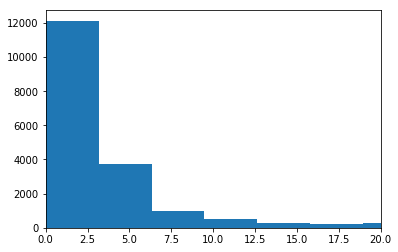

In [25]:
pl.hist(res,bins=20)
pl.xlim(0,20)
pl.show()